# Train The Defect Detection Model

This training script is responsible for fine-tuning an EfficientNet-b4 model on our defect dataset. This notebook is a modifed version of the notebook from this tutorial: https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/

In [22]:

import os
import keras
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import tensorflow as tf
from keras.layers.core import Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torch.utils.data import random_split

from modules.datasets import DefectDataset, save_classification_dataset

## Dataset

First, we load the defect dataset and save it to the defect folder with an 70%/20%/10% train-val-test split.

In [23]:
defect_dataset_dir = os.path.join('..', 'dataset', 'defect')
train_dataset_dir = os.path.join(defect_dataset_dir, 'train')
val_dataset_dir = os.path.join(defect_dataset_dir, 'val')
test_dataset_dir = os.path.join(defect_dataset_dir, 'test')

os.makedirs(train_dataset_dir, exist_ok=True)
os.makedirs(val_dataset_dir, exist_ok=True)
os.makedirs(test_dataset_dir, exist_ok=True)

In [24]:
defect_dataset = DefectDataset()
dataset_len = len(defect_dataset)

# Split the dataset into train, validation and test sets, making sure that the size of each split adds up to the size of the original dataset.
train_dataset, val_dataset, test_dataset = random_split(defect_dataset, [round(dataset_len * 0.7), round(dataset_len * 0.2), round(dataset_len - dataset_len * .9)])

In [25]:
classnames = ['defective', 'normal']
save_classification_dataset(train_dataset, train_dataset_dir, classes=classnames)
save_classification_dataset(val_dataset, val_dataset_dir, classes=classnames)
save_classification_dataset(test_dataset, test_dataset_dir, classes=classnames)

Saving dataset to ..\dataset\defect\test: 100%|██████████| 383/383 [00:00<00:00, 417.29it/s]


In [26]:


# Splitting the ds into training data and resizing it to 224 * 224 to make it uniform.
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_dir,
    class_names=classnames,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 2642 files belonging to 2 classes.


In [27]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dataset_dir,
    class_names=classnames,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 754 files belonging to 2 classes.


In [28]:
# Splitting the ds into validation data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_dir,
    seed=123,
    class_names=classnames,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 377 files belonging to 2 classes.


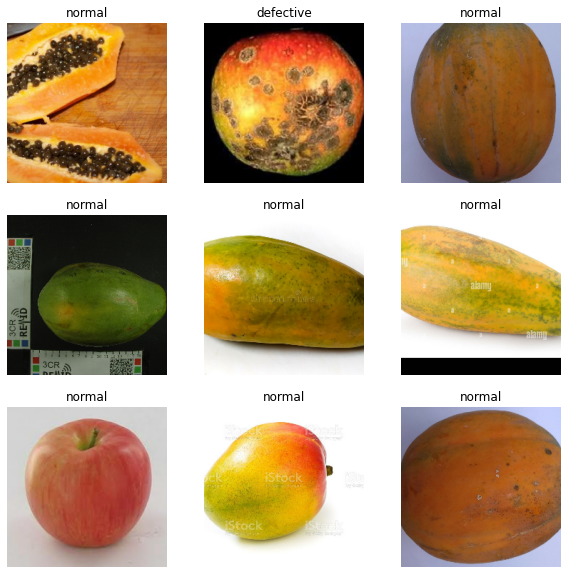

In [29]:

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classnames[labels[i]])
        plt.axis("off")


## Model

We use a pre-trained EfficientNet-b4 model and fine-tune it on our defect dataset.

In [30]:
# Importing EfficientNetB4
efficientnet_model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=2,
    classifier_activation="softmax")


for layer in efficientnet_model.layers:
        layer.trainable=False

In [31]:
# Importing pre trained model

defect_model = Sequential([
    efficientnet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

In [32]:
# Model Summary
defect_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 flatten_1 (Flatten)         (None, 1792)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               918016    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 18,592,865
Trainable params: 919,042
Non-trainable params: 17,673,823
_________________________________________________________________


## Training



In [33]:
# Training

defect_model.compile(optimizer=Adam(learning_rate=0.002),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [34]:
epochs=8

history = defect_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
83/83 [==============================] - 39s 358ms/step - loss: 0.3122 - accuracy: 0.8637 - val_loss: 0.2522 - val_accuracy: 0.9032
Epoch 2/8
83/83 [==============================] - 24s 284ms/step - loss: 0.1845 - accuracy: 0.9258 - val_loss: 0.2500 - val_accuracy: 0.9151
Epoch 3/8
83/83 [==============================] - 23s 269ms/step - loss: 0.1411 - accuracy: 0.9421 - val_loss: 0.2613 - val_accuracy: 0.9151
Epoch 4/8
83/83 [==============================] - 24s 289ms/step - loss: 0.1082 - accuracy: 0.9603 - val_loss: 0.2350 - val_accuracy: 0.9284
Epoch 5/8
83/83 [==============================] - 24s 281ms/step - loss: 0.1120 - accuracy: 0.9527 - val_loss: 0.2477 - val_accuracy: 0.9271
Epoch 6/8
83/83 [==============================] - 23s 269ms/step - loss: 0.0744 - accuracy: 0.9701 - val_loss: 0.2565 - val_accuracy: 0.9324
Epoch 7/8
83/83 [==============================] - 23s 268ms/step - loss: 0.0723 - accuracy: 0.9724 - val_loss: 0.3447 - val_accuracy: 0.9085
Epoch 

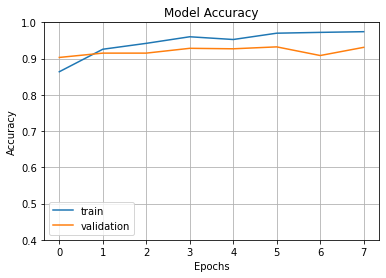

In [35]:
# Model Evaluation

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Now that the model is done training, we can save it. We save the model using a Keras SavedModel format. We need to copy the model to the weights folder before we can use it in DeepFruitVision.

In [36]:
# save the model
defect_model.save("defect_model")

INFO:tensorflow:Assets written to: defect_model\assets


INFO:tensorflow:Assets written to: defect_model\assets


## Evaluation

Now that we're done training the model, we can evaluate it on the test set, and we can create a confusion matrix to see how well the model performed.

In [37]:
defect_model.evaluate(test_ds)

12/12 [==============================] - 4s 245ms/step - loss: 0.2748 - accuracy: 0.9098


[0.27479225397109985, 0.9098142981529236]

In [38]:
predictions = []
labels = []
for x, y in test_ds:
    predicted_categories = np.argmax(defect_model.predict(x), axis = 1)
    predictions.append(predicted_categories)
    labels.append(y)


predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

print(predictions.shape)
print(labels.shape)
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

1/1 [==============================] - 2s 2s/step
(377,)
(377,)


array([[168,  13],
       [ 21, 175]])

In [39]:
print(classification_report(labels, predictions, target_names=classnames))

              precision    recall  f1-score   support

   defective       0.89      0.93      0.91       181
      normal       0.93      0.89      0.91       196

    accuracy                           0.91       377
   macro avg       0.91      0.91      0.91       377
weighted avg       0.91      0.91      0.91       377



Now lets take a look at some of the model's predictions on the test set.

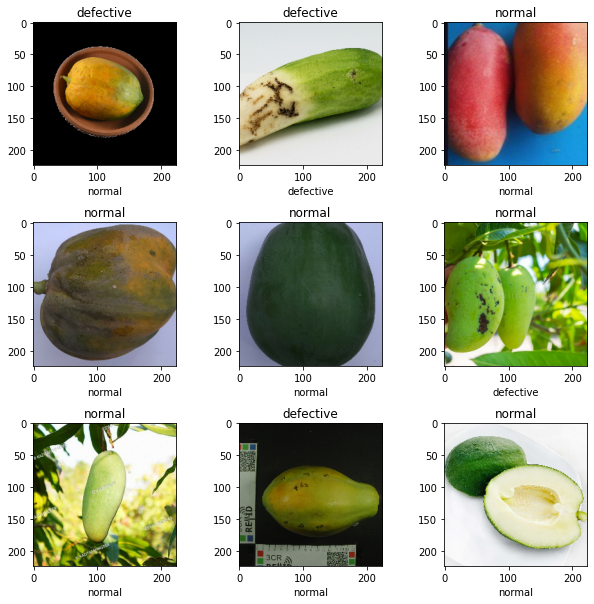

In [40]:
# Plotting some of the predictions using matplotlib

plt.figure(figsize=(10, 10))
# increase the space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[int(predictions[i])])
    # also print the true label
    plt.xlabel(classnames[labels[i]])
    #plt.axis("off")
plt.show()

Now that we are done with training and evaluation, we can clean up the defect dataset folder we created to save on disk space. This also lets us cleanly rerun the notebook without having to worry any dataset conflicts

In [41]:
import shutil

# Cleaning up the defect dataset folder
shutil.rmtree(defect_dataset_dir)